## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-14 13:12:35.233 | INFO     |  Running on cuda:0


In [3]:
task = 'PushButtons'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-14 13:12:36.129 | INFO     |  Loading dataset(s): 
2024-08-14 13:12:36.130 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/PushButtons/demos/metadata.json
2024-08-14 13:12:36.135 | INFO     |    Extracted gt object labels [82, 86, 87, 88, 91, 94, 95]
2024-08-14 13:12:36.135 | INFO     |    Extracted tsdf object labels []
2024-08-14 13:12:36.135 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-08-14 13:12:38.442 | INFO     |  Subsampling to length 66 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    trans_cov_mask_t_pos_corr = False,

    em_steps=1,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=5e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=3,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-14 13:12:38.523 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:12:38.523 | INFO     |  Performing fitting actions: [INIT]
2024-08-14 13:12:38.524 | INFO     |  Segmenting trajectories


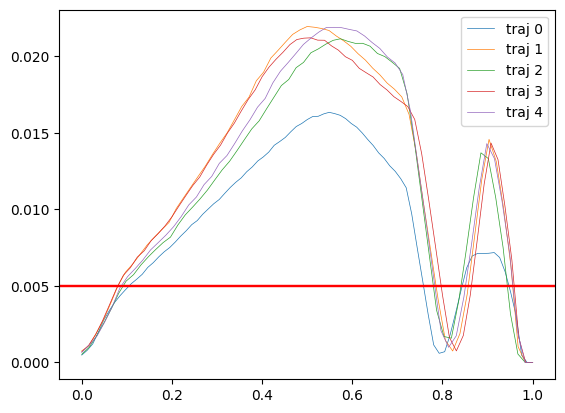

2024-08-14 13:12:38.621 | INFO     |  Creating segement of demos.
2024-08-14 13:12:38.622 | INFO     |  Subsampling to length 53 using strategy mean-length.
2024-08-14 13:12:38.622 | INFO     |  Creating segement of demos.
2024-08-14 13:12:38.624 | INFO     |  Subsampling to length 13 using strategy mean-length.
2024-08-14 13:12:38.624 | INFO     |  ... created 2 segments
2024-08-14 13:12:38.624 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:12:38.624 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:12:38.626 | WARNING  |    Riemannian GMMs only make sense for rotations.
2024-08-14 13:12:38.626 | INFO     |    Manifold: TIME x R3 x R1
2024-08-14 13:12:38.626 | INFO     |    Changing number of components to 8
2024-08-14 13:12:38.626 | INFO     |    Model init ...


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:12:38.641 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:12:38.641 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:12:38.667 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:12:38.667 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:12:38.681 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:12:38.681 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:12:38.738 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-14 13:12:38.739 | INFO     |  obj000     score (rel):     -1 (0.998)
2024-08-14 13:12:38.739 | INFO     |  obj001     score (rel):     -0 (0.142)
2024-08-14 13:12:38.739 | INFO     |  obj002     score (rel):     -0 (0.086)
2024-08-14 13:12:38.739 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:12:38.740 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:12:38.740 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:12:38.743 | INFO     |    Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:12:38.763 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:12:38.764 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:12:38.779 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:12:38.779 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:12:38.797 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:12:38.797 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-14 13:12:38.820 | INFO     |  ee_init    score (rel):     -0 (0.002)
2024-08-14 13:12:38.820 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-08-14 13:12:38.821 | INFO     |  obj001     score (rel):     -0 (0.002)
2024-08-14 13:12:38.821 | INFO     |  obj002     score (rel):     -0 (0.001)
2024-08-14 13:12:38.821 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:12:38.822 | INFO     |  Segmented trajs into 2 segments
2024-08-14 13:12:38.825 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002
Segment 0 -0.995839 -0.993626 -0.141089 -0.085411
Segment 1 -0.001604 -0.995069 -0.002165 -0.001187
2024-08-14 13:12:38.826 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002
Segment 0  1.000000  0.997777  0.141678  0.085768
Segment 1  0.001611  1.000000  0.002176  0.001193


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:12:38.846 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/8 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[10495203.  , 10488682.93,  6793492.21, ...,        0.  ,
                 0.  ,        0.  ],
         [  647354.54,  1220766.09,  2011471.4 , ...,        0.  ,
                 0.  ,        0.  ],
         [       0.33,        3.14,       23.77, ...,        0.  ,
                 0.  ,        0.  ],
         ...,
         [       0.  ,        0.  ,        0.  , ...,        2.69,
                 0.46,        0.08],
         [       0.  ,        0.  ,        0.  , ...,   976532.34,
            479251.08,   222313.97],
         [       0.  ,        0.  ,        0.  , ...,   823142.5 ,
           1046962.52,   811081.07]]),
  array([[530580.95, 530441.39, 316739.97, 111284.13,  22010.68,   1647.17,
              89.94,      2.73,      0.02,      0.  ,      0.  ,      0.  ,
               0.  , 530534.7 , 530423.99, 323724.81, 117172.15,  22756.77,
            1976.75,     64.62,      3.49,      0.03,      0.  ,      0.  ,
               0.  ,      0.  , 529570.18, 530580.65, 32

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-14 13:12:39.013 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-14 13:12:39.063 | WARNING  |  Skippig NaN Gaussians.


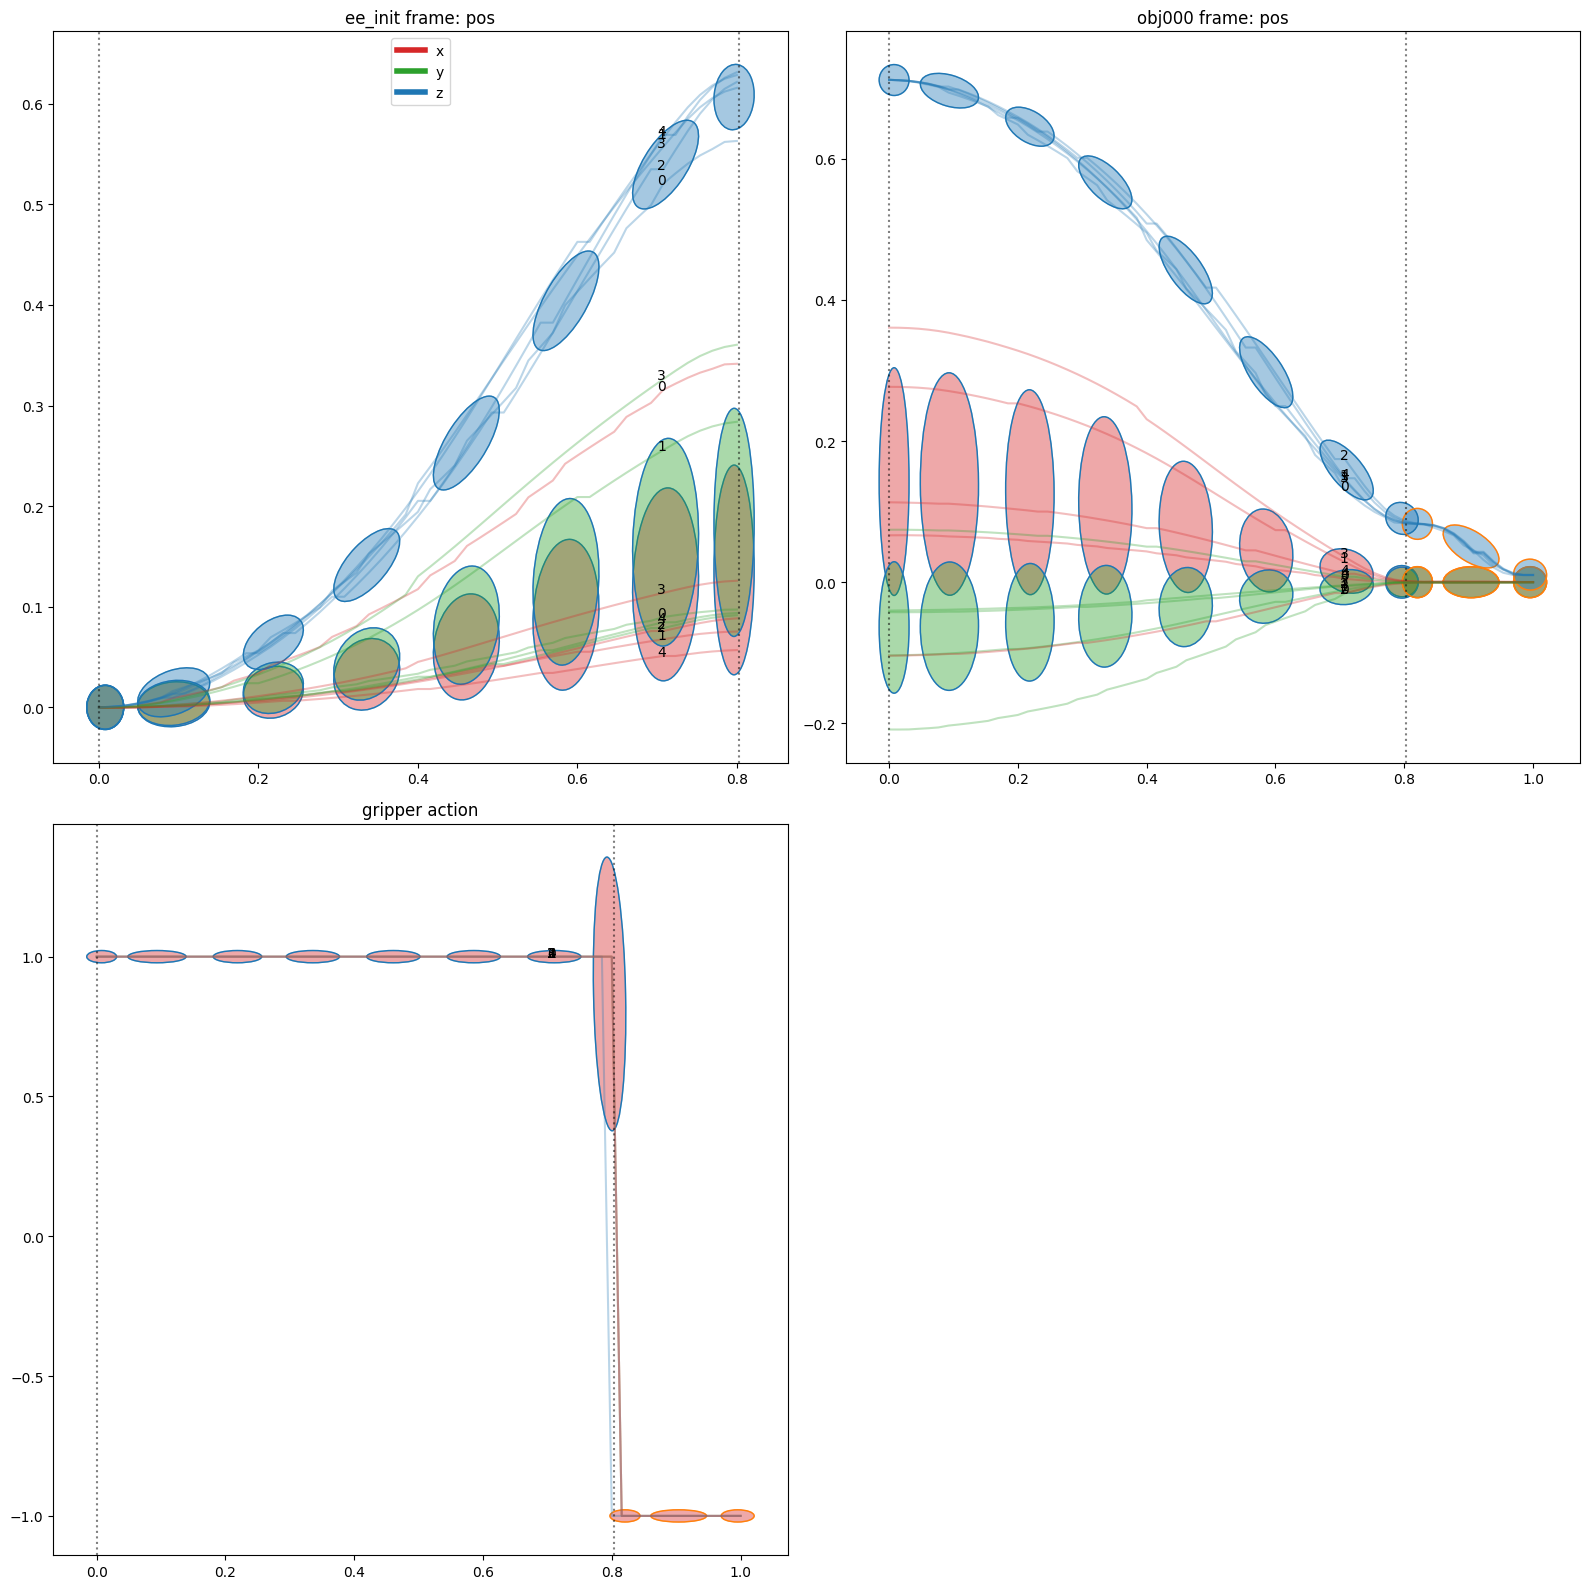

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-08-14 13:12:40.283 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:12:40.284 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-14 13:12:40.288 | INFO     |  HMM EM ...
2024-08-14 13:12:40.289 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-14 13:12:40.297 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-14 13:12:40.357 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[0.94, 0.9 , 0.77, ..., 0.  , 0.  , 0.  ],
         [0.06, 0.1 , 0.23, ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.54, 0.31, 0.22],
         [0.  , 0.  , 0.  , ..., 0.46, 0.69, 0.78]]),
  array([[0.94, 0.89, 0.74, 0.39, 0.09, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.95, 0.89, 0.74, 0.41, 0.09, 0.01, 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.94, 0.89, 0.75, 0.42, 0.1 , 0.01, 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.95, 0.89, 0.74, 0.42, 0.09,
          0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.94, 0.89, 0.75,
          0.42, 0.1 , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.06, 0.11, 0.26, 0.61, 0.91, 0.99, 1.  , 0.96, 0.7 , 0.33, 0.13,
          0.06, 0.03, 0.05, 0.11, 0.26, 0.59, 0.91, 0.99, 0.99, 0.96, 0.73,
          0.33, 0.13, 0.06, 0.03, 0.06, 0.11, 0.25, 0.58, 0.9 , 0.99,

2024-08-14 13:12:40.497 | INFO     |  Did not specify time_based, deciding automatically.


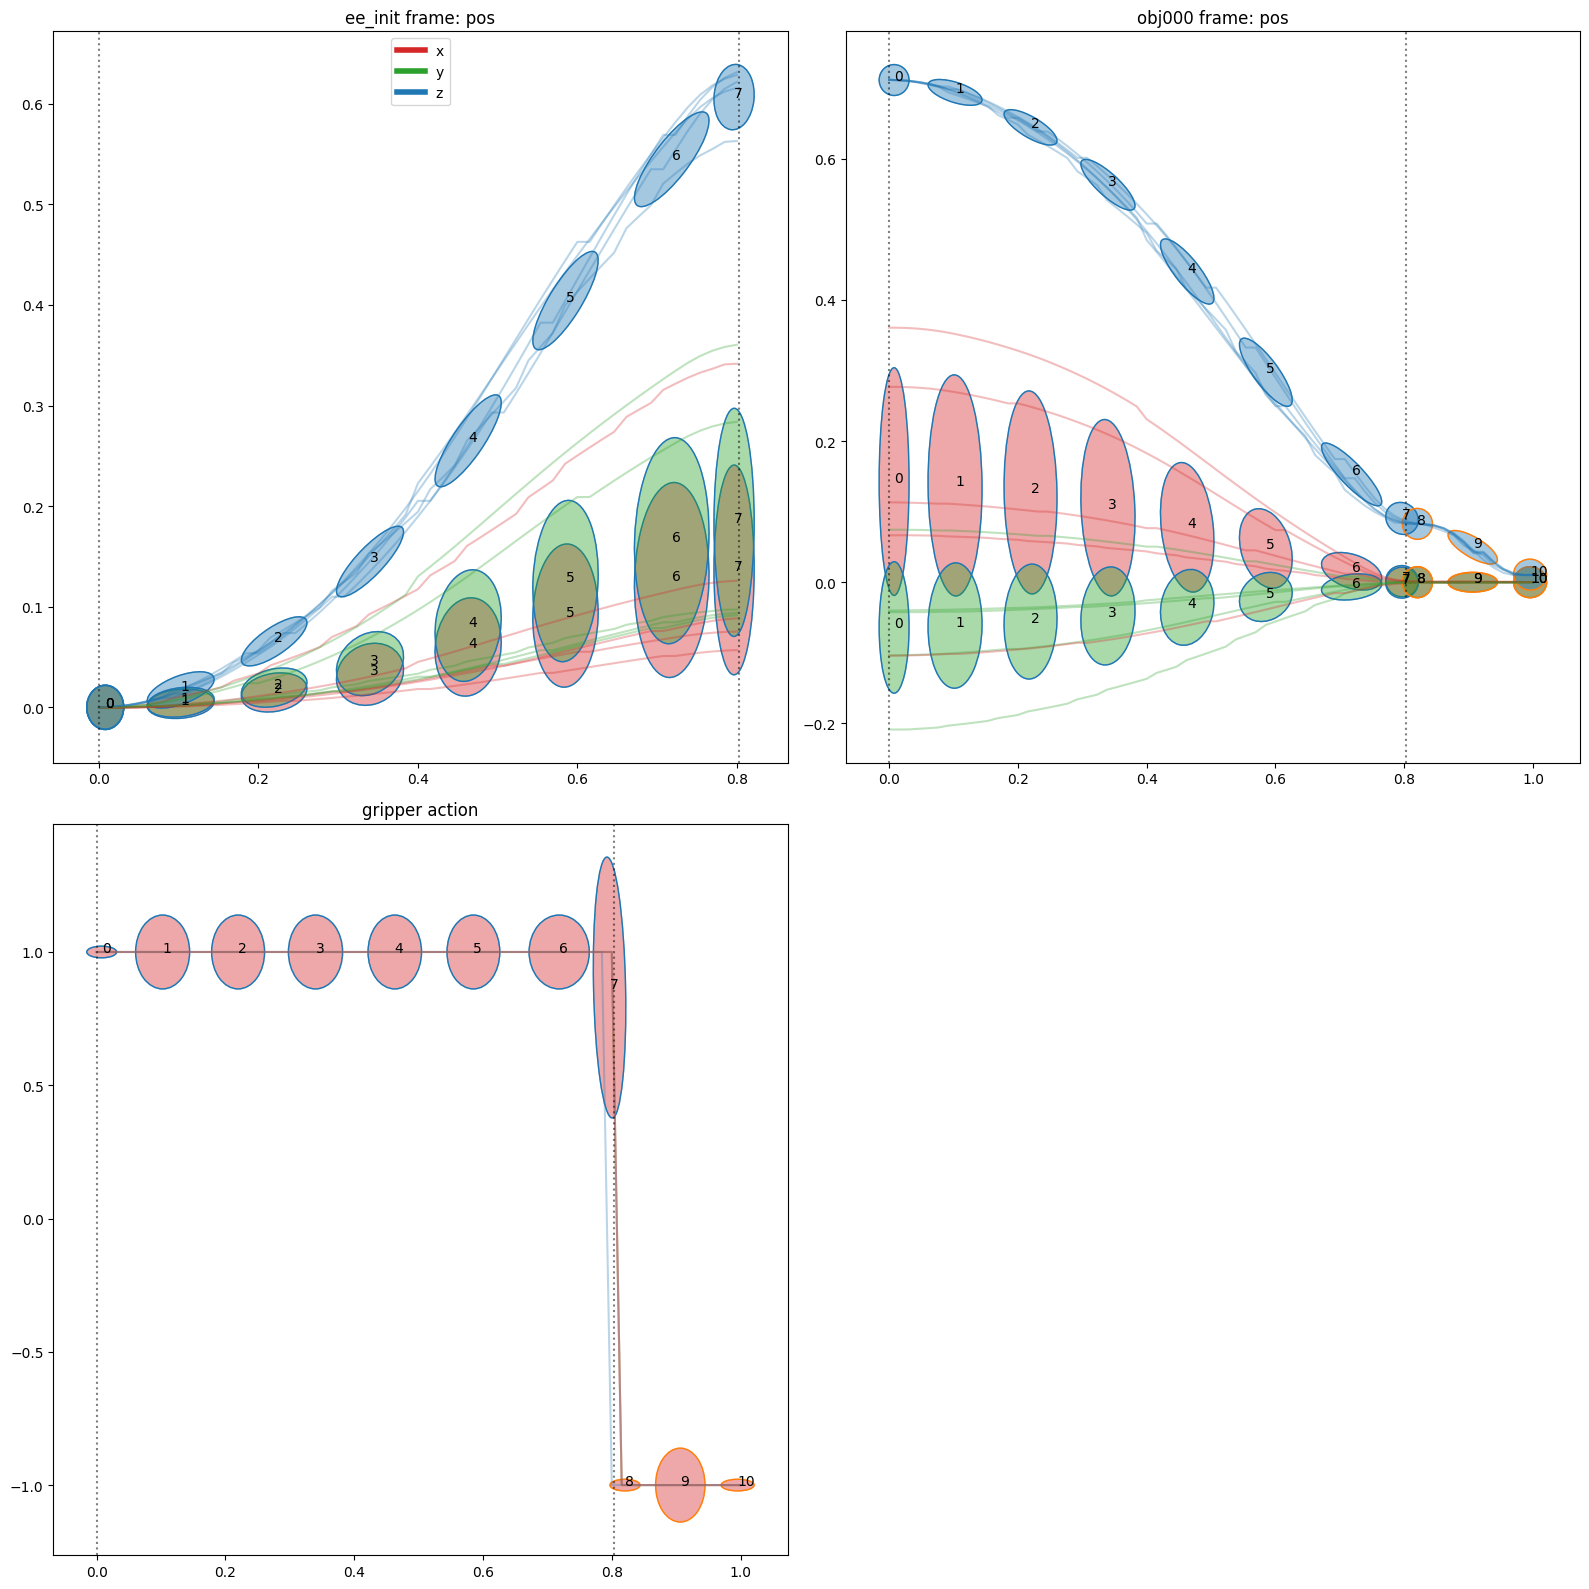

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

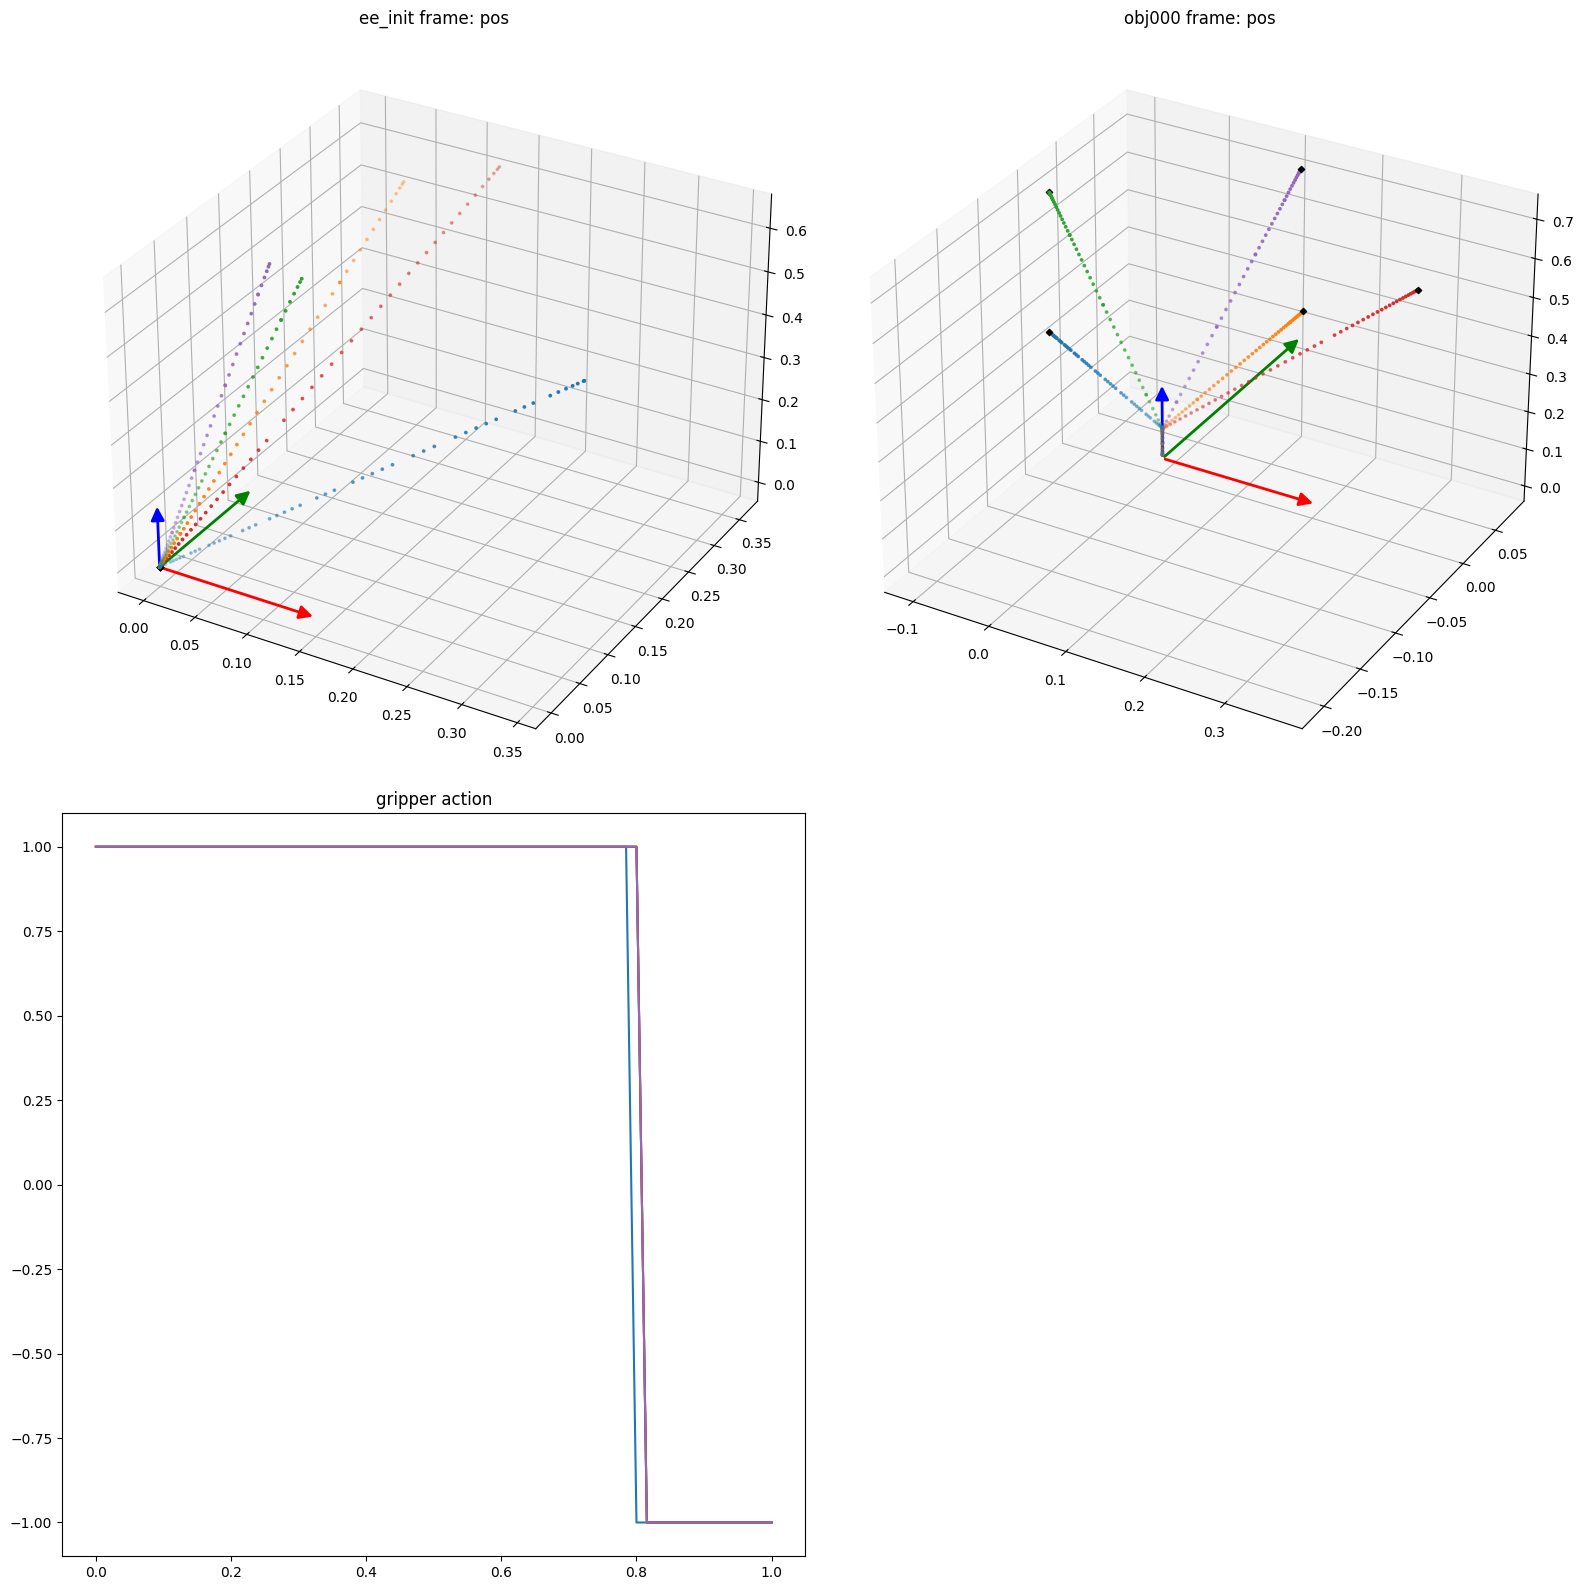

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

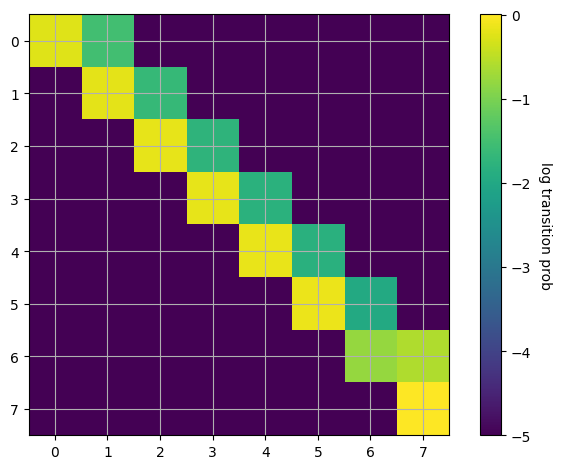

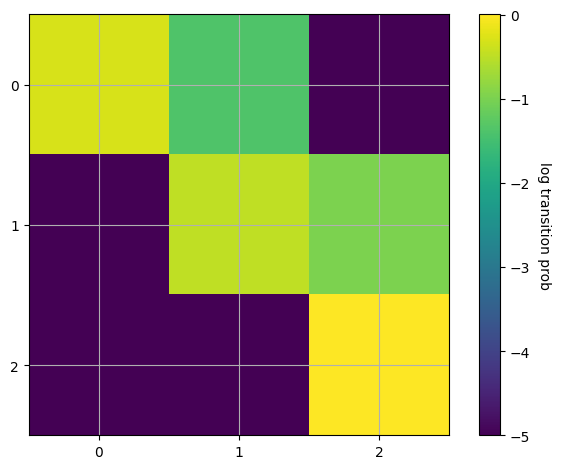

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-14 13:12:42.399 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-14 13:12:42.498 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-14 13:12:42.509 | INFO     |  Caculated segment transition probabilities: (array([[0.94]]),)
2024-08-14 13:12:42.509 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:12:42.511 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:12:42.546 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:12:42.565 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

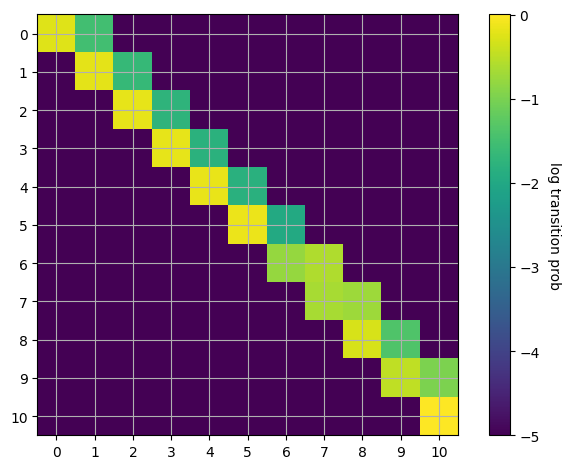

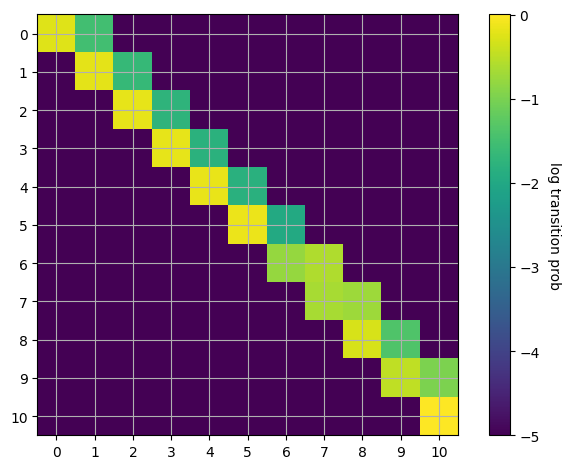

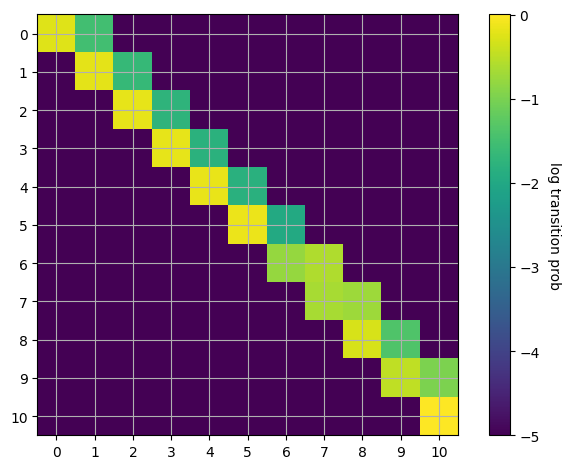

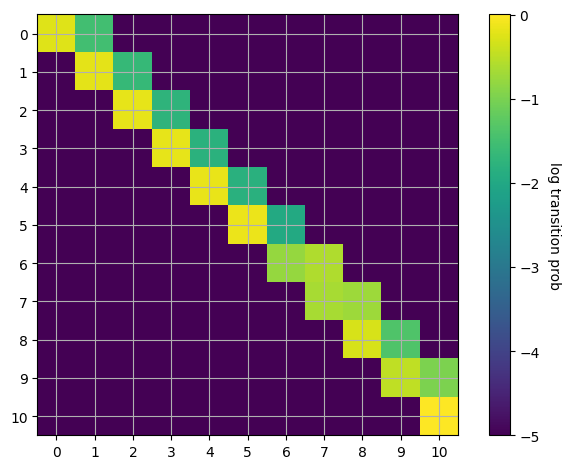

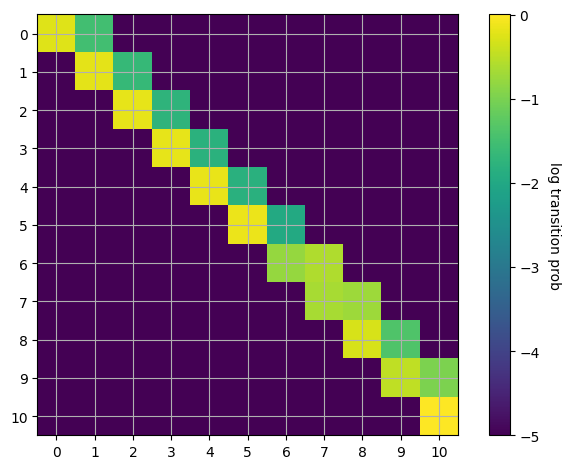

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:12:43.677 | INFO     |  Taking frame origins from demos.


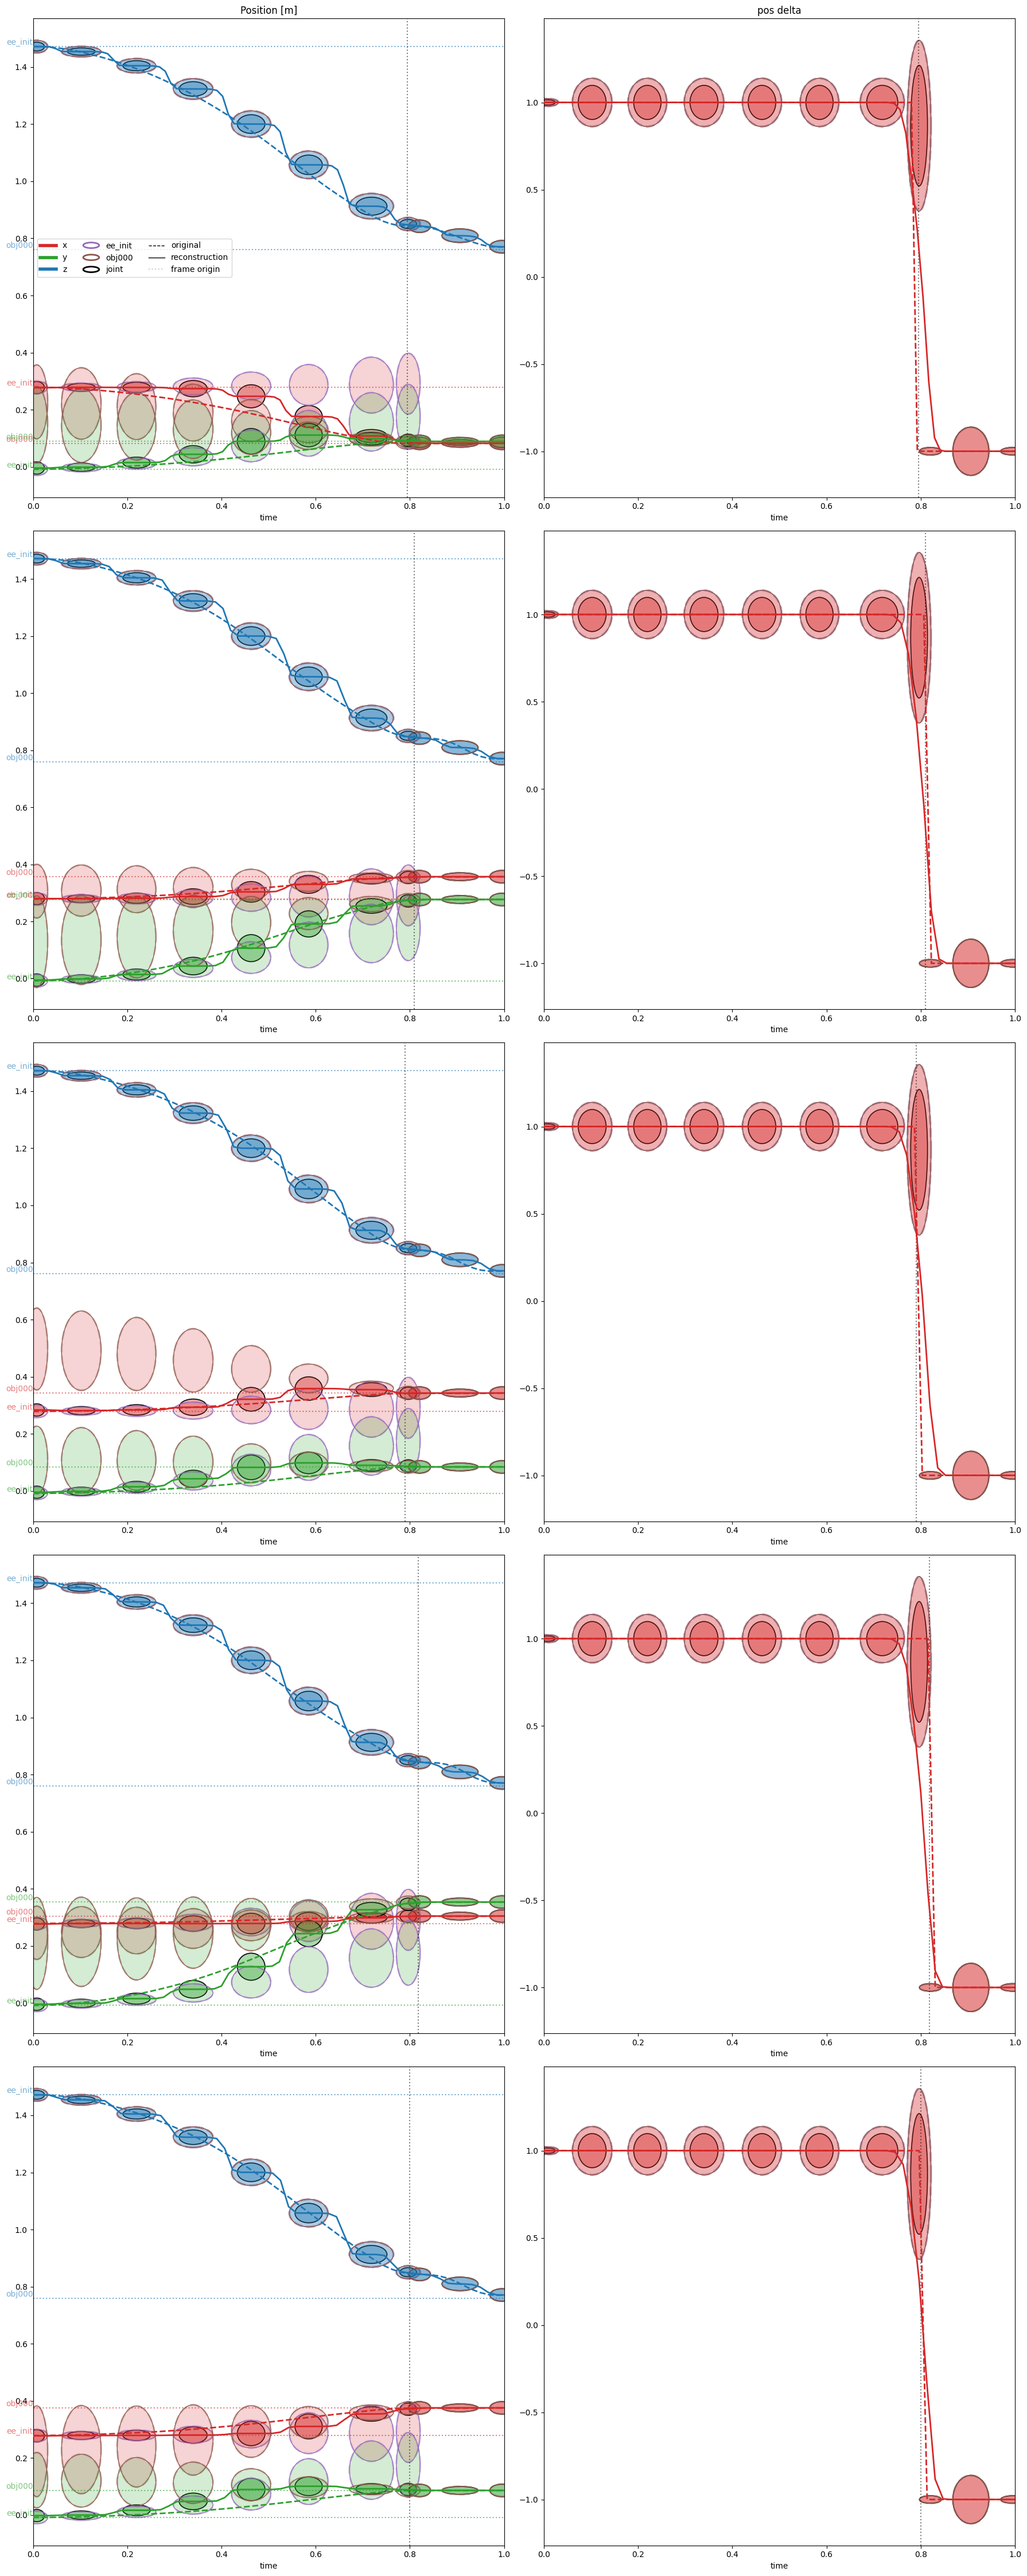

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:12:47.564 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


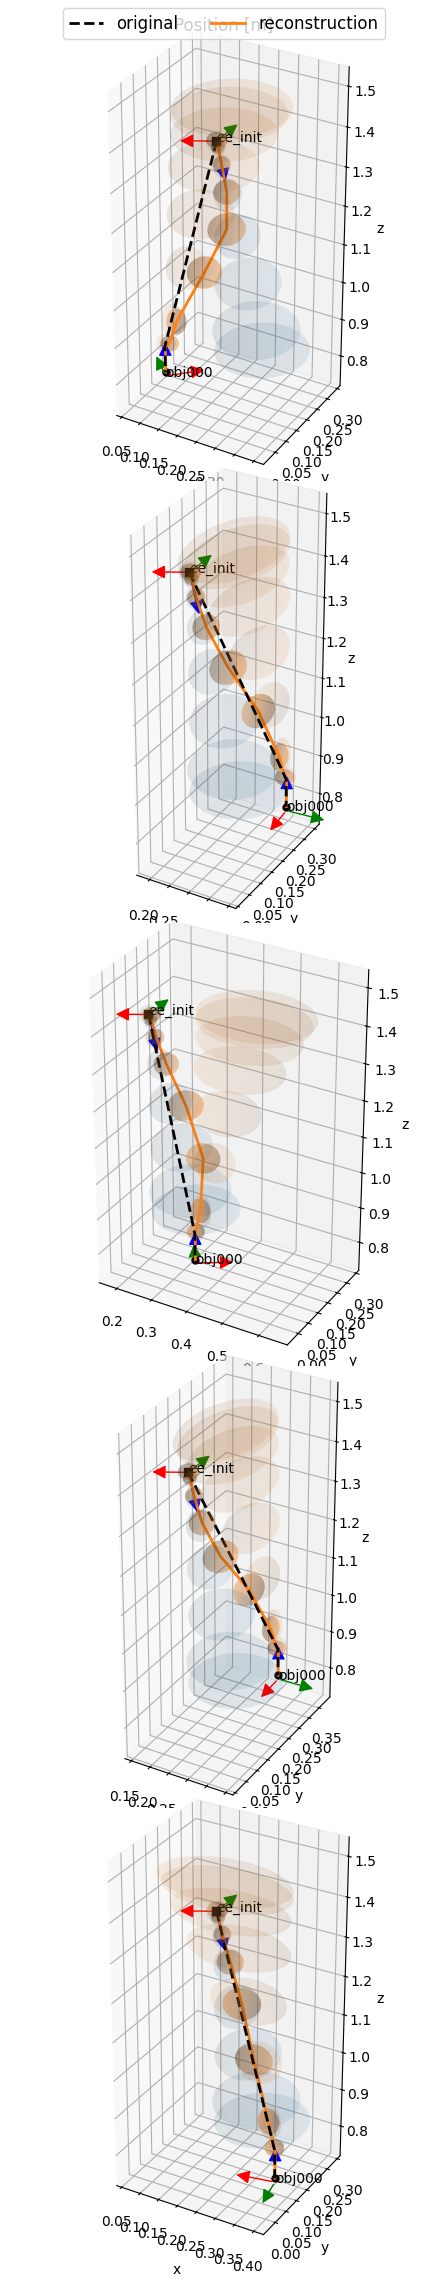

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
